In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import datasets
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score
import os
import keras as K
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
os.environ['TF_CPP_MIN_LOG_LEVEL']= '2'

In [ ]:
# !gdown --id '1S9iwczSf6KL5jMSmU20SXKCSD3BUx4o_' --output level-6.csv #GMPR_genus
!gdown --id '1q0yp1iM66BKvqee46bOuSZYwl_SJCTp0' --output level-6.csv #GMPR_species

Downloading...
From: https://drive.google.com/uc?id=1q0yp1iM66BKvqee46bOuSZYwl_SJCTp0
To: /content/level-6.csv
100% 1.67M/1.67M [00:00<00:00, 61.1MB/s]


In [ ]:
train = pd.read_csv("level-6.csv")
train.head()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443 entries, 0 to 442
Columns: 1139 entries, index to Diagnosis
dtypes: float64(785), int64(352), object(2)
memory usage: 3.8+ MB


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
train["Diagnosis"] = labelencoder.fit_transform(train["Diagnosis"])
# test["Diagnosis"] = labelencoder.fit_transform(test["Diagnosis"])
# for i in range(len(train)):
#     if train["Diagnosis"][i] == 'Cancer':
#         train["Diagnosis"][i] = str(1)
#     else:
#         train["Diagnosis"][i] = str(0)
train

,index,Archaea.Euryarchaeota.Methanobacteria.Methanobacteriales.Methanobacteriaceae.Methanobrevibacter.__,Archaea.Euryarchaeota.Methanobacteria.Methanobacteriales.Methanobacteriaceae.Methanosphaera.__,Archaea.Euryarchaeota.Methanomicrobia.Methanosarcinales.Methanosarcinaceae.Methanococcoides.,Archaea.Thermoplasmatota.Thermoplasmata.Methanomassiliicoccales.Methanomassiliicoccaceae.Methanomassiliicoccus.__,Archaea.Thermoplasmatota.Thermoplasmata.Methanomassiliicoccales.Methanomethylophilaceae.Candidatus_Methanomethylophilus.__,Archaea.Thermoplasmatota.Thermoplasmata.Methanomassiliicoccales.Methanomethylophilaceae.uncultured.__,Bacteria.Acidobacteriota.Acidobacteriae.Acidobacteriales.Acidobacteriaceae_.Subgroup_1..Acidobacterium.uncultured_organism,Bacteria.Actinobacteria.Actinobacteria.Actinomycetales.Actinomycetaceae..__,Bacteria.Actinobacteria.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.,Bacteria.Actinobacteria.Actinobacteria.Propionibacteriales.Propionibacteriaceae.Propionibacterium.,Bacteria.Actinobacteria.Coriobacteriia.Coriobacteriales.Coriobacteriaceae.FCNB.PAC002389,Bacteria.Actinobacteria.Coriobacteriia.Coriobacteriales.Coriobacteriaceae.PAC002528.PAC002528,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.Actinomyces_graevenitzii,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.Winkia_neuii,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Actinomyces.human_gut_metagenome,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Arcanobacterium.Chlamydia_trachomatis,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Arcanobacterium.uncultured_bacterium,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.F0332.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Mobiluncus.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Trueperella.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.Varibaculum.__,Bacteria.Actinobacteriota.Actinobacteria.Actinomycetales.Actinomycetaceae.__.__,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Alloscardovia.uncultured_bacterium,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Bifidobacterium.Bifidobacterium_bifidum,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Bifidobacterium.__,Bacteria.Actinobacteriota.Actinobacteria.Bifidobacteriales.Bifidobacteriaceae.Scardovia.__,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.Corynebacterium_durum,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.Corynebacterium_sp._oral_taxon_B00,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Corynebacterium.__,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Corynebacteriaceae.Lawsonella.__,Bacteria.Actinobacteriota.Actinobacteria.Corynebacteriales.Nocardiaceae.Rhodococcus.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Glutamicibacter.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Kocuria.Rothia_kristinae,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Kocuria.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Micrococcus.__,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Rothia.Rothia_dentocariosa,Bacteria.Actinobacteriota.Actinobacteria.Micrococcales.Micrococcaceae.Rothia.__,Bacteria.Actinobacteriota.Coriobacteriia.Coriobacteriales.Atopobiaceae.Atopobium.Atopobium_fossor,...,Bacteria.Synergistota.Synergistia.Synergistales.Synergistaceae.Cloacibacillus.__,Bacteria.Synergistota.Synergistia.Synergistales.Synergistaceae.Fretibacterium.Synergi

In [ ]:
not_select = ["index", "Diagnosis"]
train_select = train.drop(not_select,axis=1)
df_final_select = train_select

# **GCN**

In [ ]:
!gdown --id '1Smw2qmdkM4KiD1EWaBxOgtHKb3IsmzOi' --output A.csv
!gdown --id '1esV5MQvMZX5HhTRRq0oLVJh6gIl2Hksw' --output D.csv
A = pd.read_csv("A.csv",header=None)
D = pd.read_csv("D.csv",header=None)

Downloading...
From: https://drive.google.com/uc?id=1Smw2qmdkM4KiD1EWaBxOgtHKb3IsmzOi
To: /content/A.csv
100% 2.33M/2.33M [00:00<00:00, 83.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1esV5MQvMZX5HhTRRq0oLVJh6gIl2Hksw
To: /content/D.csv
100% 394k/394k [00:00<00:00, 69.6MB/s]


In [ ]:
A = A.to_numpy()
D = D.to_numpy()
# df_final_select = df_final_select.to_numpy()

In [ ]:
print('A = ',A)
print('D = ',D)

A =  [[0.         0.55489435 0.96415354 ... 0.91180464 0.87872847 0.89751424]
 [0.55489435 0.         0.67895668 ... 0.59013231 0.61063586 0.72154047]
 [0.96415354 0.67895668 0.         ... 0.98446385 0.91138411 0.90750005]
 ...
 [0.91180464 0.59013231 0.98446385 ... 0.         0.66077706 0.71147635]
 [0.87872847 0.61063586 0.91138411 ... 0.66077706 0.         0.84064257]
 [0.89751424 0.72154047 0.90750005 ... 0.71147635 0.84064257 0.        ]]
D =  [[ 86   0   0 ...   0   0   0]
 [  0 108   0 ...   0   0   0]
 [  0   0 156 ...   0   0   0]
 ...
 [  0   0   0 ... 165   0   0]
 [  0   0   0 ...   0 240   0]
 [  0   0   0 ...   0   0 189]]


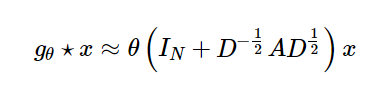

In [ ]:
x = df_final_select.to_numpy()
I = np.eye(443)
g_theta = np.matmul((I + ((D**0.5)*A*(D**0.5))),x)
print(g_theta)

[[0.         0.         0.         ... 0.         0.         0.39634556]
 [0.         0.         0.         ... 0.         0.         0.97709737]
 [0.         0.         0.         ... 0.         0.         1.57099617]
 ...
 [0.         0.         0.         ... 0.         0.         2.15070381]
 [0.         0.         0.         ... 0.         0.         2.51611436]
 [0.         0.         0.         ... 0.         0.         3.58127522]]


In [ ]:
x = g_theta
y = train['Diagnosis']
train_x, test_x, train_y, test_y = train_test_split(x,y,test_size=0.2,random_state=0)
print(train_x.shape)
print(test_x.shape)

# train_x = train_x.values.reshape(354, 1, 1, 1367)
train_x = train_x.reshape(354, 1, 379, 3)
# test_x = test_x.values.reshape(89, 1, 1, 1367)
test_x = test_x.reshape(89, 1, 379, 3)
train_x = tf.image.resize(train_x, (128, 128))
test_x = tf.image.resize(test_x, (128, 128))

print(train_x.shape)
print(test_x.shape)

(354, 1137)
(89, 1137)
(354, 1, 379, 3)
(89, 1, 379, 3)


## Model

In [ ]:
model = K.models.Sequential()
model.add(K.layers.Conv2D(3, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
model.add(K.layers.Conv2D(50, (1, 1), activation='relu', input_shape=train_x.shape[1:]))
# model.add(K.layers.MaxPooling2D((2, 2)))
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Dense(12, activation= 'relu'))
model.add(K.layers.BatchNormalization(axis=1, momentum=0.99, epsilon=1e-05, center=True, scale=True))
model.add(K.layers.Dropout(0.15))
model.add(K.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 379, 3)         12        
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 379, 50)        200       
                                                                 
 flatten (Flatten)           (None, 18950)             0         
                                                                 
 batch_normalization (BatchN  (None, 18950)            75800     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 12)                227412    
                                                                 
 batch_normalization_1 (Batc  (None, 12)               48        
 hNormalization)                                        

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
# opt = K.optimizers.Adam(lr=0.0005)
model.compile(optimizer=opt, loss='binary_crossentropy',
        metrics=['accuracy'])

h2 = model.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(test_x, test_y), callbacks=[callback])
# h2 = model.fit(train_x, train_y, epochs=20, batch_size=8, validation_data=(test_x, test_y), callbacks=[callback])

Epoch 1/20
45/45 [==============================] - 2s 13ms/step - loss: 0.7376 - accuracy: 0.6102 - val_loss: 0.6616 - val_accuracy: 0.7303
Epoch 2/20
45/45 [==============================] - 0s 9ms/step - loss: 0.4927 - accuracy: 0.7345 - val_loss: 0.6594 - val_accuracy: 0.7416
Epoch 3/20
45/45 [==============================] - 0s 8ms/step - loss: 0.3729 - accuracy: 0.8305 - val_loss: 0.6546 - val_accuracy: 0.6854
Epoch 4/20
45/45 [==============================] - 0s 9ms/step - loss: 0.2973 - accuracy: 0.8785 - val_loss: 0.6538 - val_accuracy: 0.6180
Epoch 5/20
45/45 [==============================] - 0s 9ms/step - loss: 0.2869 - accuracy: 0.9068 - val_loss: 0.6691 - val_accuracy: 0.6404
Epoch 6/20
45/45 [==============================] - 0s 9ms/step - loss: 0.2738 - accuracy: 0.8983 - val_loss: 0.6645 - val_accuracy: 0.6180
Epoch 7/20
45/45 [==============================] - 0s 9ms/step - loss: 0.2181 - accuracy: 0.9576 - val_loss: 0.6164 - val_accuracy: 0.6966
Epoch 8/20
45/45 [=

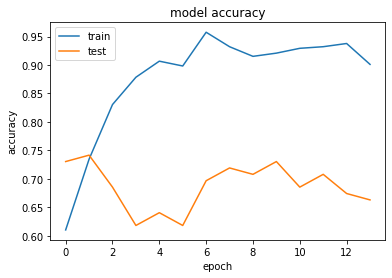

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['accuracy'])
plt.plot(h2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

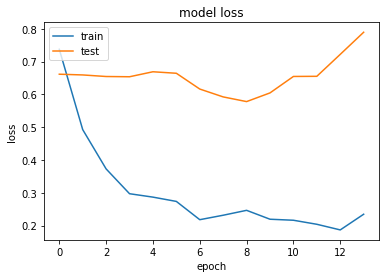

In [ ]:
# summarize history for accuracy
plt.plot(h2.history['loss'])
plt.plot(h2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(test_x)
# print(y_pred)
for i in range(len(y_pred)):
  if y_pred[i]<0.5:
    y_pred[i] = 0
  else:
    y_pred[i] = 1

precision =  <function precision_score at 0x7f06c1e2f830>
recall =  [0.64705882 0.74545455]
auc_roc =  0.6962566844919786
f1_score =  <function f1_score at 0x7f06c1e2f4d0>
Model Saved


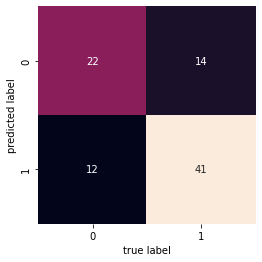

In [ ]:
mat = confusion_matrix(test_y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
score_recall = recall_score(test_y, y_pred, average=None)
f1score = f1_score(test_y, y_pred, average="macro")
precisionscore = precision_score(test_y, y_pred, average=None)
auc_roc = roc_auc_score(test_y, y_pred)
print("precision = ",precision_score)
print("recall = ",score_recall)
print("auc_roc = ",auc_roc)
print("f1_score = ",f1_score)

with open('Node_GCN_result.csv','w') as f:
    f.write('Precision_Normal,Precision_Cancer,Recall_Normal,Recall_Cancer,Auc_Score,F1_Score,')
    f.write('\n')
    f.write(str(precisionscore[0])+','+str(precisionscore[1])+','+str(score_recall[0])+','+str(score_recall[1])+','+str(auc_roc)+','+str(f1score))
model.save('CRC_Node_GCN.h5')
print('Model Saved')